# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = 'data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.
EBOLA = DATA_FOLDER + "/ebola"
GUINEA = EBOLA + "/guinea_data"
LIBERIA = EBOLA + "/liberia_data"
SIERRA_LEONE = EBOLA + "/sl_data"

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### 1.1 Importing the data

First of all, we will split the cleaning in three parts, one for each country, since the files were consistent for each country. Hence, we start by loading all of the data from each folder into three different DataFrames. 

In [2]:
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
pd.options.mode.chained_assignment = None
%config InlineBackend.figure_format = 'retina'

# A few helper functions

"""
Returns a pandas dataframe from a folder full of 
csv files.
"""
def create_folder_data_frame(FOLDER):
    list_ = []
    for file_ in glob.glob(FOLDER + "/*.csv"):
        df = pd.read_csv(file_, index_col=None)
        list_.append(df)
    return pd.concat(list_)

"""
Sets a new column "Country" that becomes part of a multi index
afterwards, and returns the indexed frame.
"""
def index_and_country(data_frame, country):
    data_frame["Country"] = country
    data_frame.set_index(['Date', 'Description', 'Country'], inplace=True)
    return data_frame
    
"""
We preprocess each Country one after the other and set their indices
to a MultiIndex of Date, Description and Country, with each column
mapped to one of these indices.
"""
def preprocess(FOLDER, name, columns=None):
    frame = create_folder_data_frame(FOLDER)
    if columns:
        frame.rename(columns=columns, inplace=True)
    frame.Date = pd.to_datetime(frame.Date)
    frame = index_and_country(frame, name)
    return frame
    
preprocessed_guinea = preprocess(GUINEA, "Guinea")

liberia_column_mapping = {"Variable": "Description", "National": "Totals", 'Unnamed: 18': "Unknown"}
preprocessed_liberia = preprocess(LIBERIA, "Liberia", liberia_column_mapping)

sierra_column_mapping = {"variable": "Description", "National": "Totals", 'Unnamed: 18': "Unknown", "date": "Date"}
preprocessed_sierra = preprocess(SIERRA_LEONE, "Sierra Leone", sierra_column_mapping)

### 1.2 Cleaning up

Now that we have our three DataFrames, we need to merge them into a single one in order to query it to get the daily average deaths and cases. What we need to do in order to merge them, is to clean each DataFrame, and create a consistency inbetween columns after choosing which columns to use.

After taking a look at the data, we decided to deliver the daily average of new cases and new deaths as a sum of the following categories: the suspected, probables, and confirmed cases and deaths, hence we only kept for each DataFrame the right columns. When the "right" columns are not perfectly defined, we explain which one we chose and why. The following set of columns are preselected after looking at the data, the other columns were either inconsistent or made no sense whatsoever.

#### 1.2.1 Guinea

In [3]:
# The columns that are of interest to us, mapped
# to their centralized names for the final DataFrame
interest = { 'New cases of suspects': 'new_suspected',
        'New cases of probables': 'new_probable',
        'New cases of confirmed': 'new_confirmed',
        'Total deaths (confirmed + probables + suspects)': 'deaths',
        'Total deaths of suspects': 'death_suspected',
        'Total deaths of probables': 'death_probable',
        'Total deaths of confirmed': 'death_confirmed' }

    
# We start by keeping only the interesting columns for the task
interest_indices = preprocessed_guinea.index.get_level_values('Description').isin(interest.keys())
guinea_df = preprocessed_guinea[interest_indices]

Now here is the first assumption we made regarding the data of Guinea, there are no missing values in the totals of deaths, but there are some NaN values in the New cases. We figured that of these new cases, NaN meant that there were either no data for the day, or that the data was not entered. It seems more plausible that people did not fill the data when there was no new cases, so we went with that explanation and changed all NaN values to 0. Also, since the number of cases and deaths can only be discrete we converted the dataframe to integers.

In [4]:
guinea_df = guinea_df.fillna(0).astype(int)
guinea_df = guinea_df.sort_index(0)

By verifying that the sum of cities and the total column are the same, we can see that there are some discrepencies. We then decided to remove the rows where the discrepencies are too high, namely 10% compared to the Totals column. Otherwise we keep the row, and we finally decided to keep mean of both columns, as they were quite similar, and it was impossible to split them apart and choose one. So the mean is the most obvious merging tool. 

In [5]:
# Keeping only the interesting columns, namely one for the Total
# and one for the total of cities, to filter out unreliable data points
guinea_df['Cities_total'] = guinea_df.sum(1) - guinea_df.Totals
guinea_df = guinea_df[['Cities_total', 'Totals']]
equality = sum(guinea_df['Cities_total'] == guinea_df['Totals']) == 0
print("Does the sum of cities equal the Totals columm ? {}".format(equality))

# Now we want to remove the rows for which the total of cities 
# diverges from the Totals column of at least 10%
guinea_df = guinea_df[np.abs(guinea_df.Cities_total - guinea_df.Totals) <= (0.1 * guinea_df.Totals)]
guinea_df['Totals'] = guinea_df.mean(1)
guinea_df = guinea_df.Totals

# Converting the indices to columns, and readjusting the indices
guinea_df = guinea_df.unstack('Description', fill_value=0)
guinea_df.rename(columns=interest, inplace=True)

display(HTML(guinea_df.to_html()))

Does the sum of cities equal the Totals columm ? False


,Description,new_confirmed,new_probable,new_suspected,deaths,death_confirmed,death_probable,death_suspected
Date,Country,,,,,,,
2014-08-04,Guinea,4.0,0.0,5.0,363.0,228.0,133.0,2.0
2014-08-26,Guinea,10.0,0.0,18.0,958.0,292.0,141.0,2.0
2014-08-27,Guinea,10.0,0.0,12.0,420.0,280.5,137.5,2.0
2014-08-30,Guinea,9.0,0.0,15.0,468.0,324.0,142.0,2.0
2014-08-31,Guinea,29.0,8.0,9.0,489.0,337.0,150.0,2.0
2014-09-02,Guinea,0.0,0.0,11.0,501.0,349.0,150.0,2.0
2014-09-04,Guinea,17.0,0.0,13.0,522.0,368.0,151.5,3.0
2014-09-07,Guinea,0.0,0.0,5.0,557.0,402.0,151.0,4.0
2014-09-08,Guinea,11.0,0.0,5.0,557.0,402.0,151.0,4.0


Looking at the total deaths, we can see that there is a row where we have missing data, we assumed here that the person forgot to write the measurements, hence we decided to fill the row with the mean of the previous and next measurements. That would simulate a linear increase and seems reasonable for one data point.

In [6]:
# Filling the row with the mean of the previous and next measurements
# We also remove the cumulative sum, in order to get the daily data
for c in guinea_df.columns:
    if "death_" in c:
        guinea_df[c].loc[('2014-09-26', 'Guinea')] = int((guinea_df[c].loc[('2014-09-24', 'Guinea')] + guinea_df[c].loc[('2014-09-30', 'Guinea')]) / 2)
        guinea_df[c] = guinea_df[c] - guinea_df[c][0]
        guinea_df[c][1:] = guinea_df[c][1:].copy().as_matrix() - guinea_df[c][:-1].copy().as_matrix()
        
# And finally, since the data can get negative because of the previous
# computations we made, we can set them back to 0
guinea_df[guinea_df < 0] = 0

Finally we can take a look at the sum of all 3 categories into one. But first, we need to choose how to process the fact that we can pick either from the deaths column or the sum of the three other categories of deaths. Let's take a look at the difference between the two.

In [7]:
guinea_df['new_cases'] = guinea_df[['new_suspected', 'new_confirmed', 'new_probable']].sum(axis=1)
guinea_df['deaths_summed'] = guinea_df[['death_confirmed', 'death_probable', 'death_suspected']].sum(axis=1)
# We reverse the cumulative sum on the deaths column to get a daily value
guinea_df['deaths'] = guinea_df['deaths'] - guinea_df['deaths'][0]
guinea_df['deaths'][1:] = guinea_df['deaths'][1:].copy().as_matrix() - guinea_df['deaths'][:-1].copy().as_matrix()

display(HTML(guinea_df[['deaths', 'deaths_summed']].to_html()))

,Description,deaths,deaths_summed
Date,Country,,
2014-08-04,Guinea,0.0,0.0
2014-08-26,Guinea,595.0,72.0
2014-08-27,Guinea,-538.0,0.0
2014-08-30,Guinea,48.0,48.0
2014-08-31,Guinea,21.0,21.0
2014-09-02,Guinea,12.0,12.0
2014-09-04,Guinea,21.0,21.5
2014-09-07,Guinea,35.0,35.0
2014-09-08,Guinea,0.0,0.0


Taking a look at the column deaths and the column death_summed, we can clearly see that they are about the same, besides a few discrepencies and two or three clearly wrong values. Hence, we decided to only retain the deaths_summed column that seemed more consistent.

In [8]:
# We now have a clean DataFrame to work with:
guinea_df = guinea_df[['new_cases', 'deaths_summed']]
guinea_df.rename(columns={'deaths_summed':'deaths'}, inplace=True)

display(HTML(guinea_df.to_html()))

,Description,new_cases,deaths
Date,Country,,
2014-08-04,Guinea,9.0,0.0
2014-08-26,Guinea,28.0,72.0
2014-08-27,Guinea,22.0,0.0
2014-08-30,Guinea,24.0,48.0
2014-08-31,Guinea,46.0,21.0
2014-09-02,Guinea,11.0,12.0
2014-09-04,Guinea,30.0,21.5
2014-09-07,Guinea,5.0,35.0
2014-09-08,Guinea,16.0,0.0


#### 1.2.2 Sierra Leone

Now for Sierra Leone, most of our assumptions still hold, so we will explain less of our choices, and quickly explain through comments. If there is something new, we will explain it more thoroughly.

In [9]:
# Setting all values to integer and replacing all NaNs by 0
preprocessed_sierra = preprocessed_sierra.apply(pd.to_numeric,errors='coerce')
preprocessed_sierra = preprocessed_sierra.fillna(0).astype(int)

# We wanted to check if the 'Police traning School' and 'Police training School' were the same
# As the sum of 'Police traning School' equals 0, we decided to drop this one
# which must have been a typo
print('Sum for Police traning: ', preprocessed_sierra['Police traning School'].sum())
print('Sum for Police training: ', preprocessed_sierra['Police training School'].sum())
preprocessed_sierra.drop('Police traning School', axis =1, inplace=True)


# Just like before, keeping only the interesting descriptions
interest = ['death_suspected',
               'new_probable',
               'new_suspected',
               'death_confirmed',
               'new_confirmed',
               'death_probable']
indices_interest = preprocessed_sierra.index.get_level_values('Description').isin(interest)
preprocessed_sierra = preprocessed_sierra[indices_interest]

Sum for Police traning:  0
Sum for Police training:  52


This time we did the columns a bit differently, same as before, we compute the sum of cities and compare it to the Totals column. We then remove outliers by computing the difference between the maximum of both columns and the mean. This is a precise metric to decide wether a point is an outlier or not, it is quite robust against the main problem: columns containing 0 values.

In [10]:
preprocessed_sierra['Cities_total'] = preprocessed_sierra.sum(axis=1) - preprocessed_sierra['Totals']
preprocessed_sierra['Mean'] = (preprocessed_sierra['Totals'] + preprocessed_sierra['Cities_total']) / 2
max_of_both = preprocessed_sierra[['Cities_total', 'Totals']].max(1)
preprocessed_sierra = preprocessed_sierra[np.abs(max_of_both - preprocessed_sierra.Mean) <= (0.1 * preprocessed_sierra.Mean)]

# We remove rows with 0 in the death columns
# Indeed these are cumulative columns and so a 0 makes no sense.
# Before we changed one row, but here there are too many rows to do this.
sierra = preprocessed_sierra['Mean'].unstack('Description', fill_value=0)
sierra = sierra[(sierra['death_suspected'] != 0) & (sierra['death_probable'] != 0) & (sierra['death_confirmed'] != 0) ]

#The data give us only the cumulated total for the deaths. So we computed the dayly numbers of deaths
deaths = ['death_suspected', 'death_probable', 'death_confirmed']
for c in sierra.columns:
    if c in deaths:
        sierra[c] = sierra[c] - sierra[c][0]
        sierra[c][1:] = sierra[c][1:].copy().as_matrix() - sierra[c][:-1].copy().as_matrix()

#Set the minimum value to 0    
sierra = sierra.clip(lower=0)
# We sum the 'suspected, probable and confirmed' columns
sierra['deaths'] = sierra[['death_suspected', 'death_probable', 'death_confirmed']].sum(1)
sierra['new_cases'] = sierra[['new_confirmed', 'new_probable', 'new_suspected']].sum(1)
sierra = sierra[['deaths', 'new_cases']]

# Here is the final dataframe for Sierra Leone
display(HTML(sierra.to_html()))

,Description,deaths,new_cases
Date,Country,,
2014-08-12,Sierra Leone,0.0,22.0
2014-08-13,Sierra Leone,9.0,19.0
2014-08-14,Sierra Leone,7.0,15.0
2014-08-15,Sierra Leone,7.0,17.0
2014-08-16,Sierra Leone,10.0,21.0
2014-08-17,Sierra Leone,8.0,3.0
2014-08-18,Sierra Leone,7.0,60.0
2014-08-19,Sierra Leone,8.0,28.0
2014-08-20,Sierra Leone,2.0,5.0


#### 1.2.3 Liberia

Exactly like the other countries, we keep the obvious columns, and analyze the others.

In [11]:
# Keeping only the interesting columns
interest_liberia = { 'New Case/s (Suspected)': 'new_suspected', 
        'New Case/s (Probable)': 'new_probable', 
        'New case/s (confirmed)': 'new_confirmed', 
        'Total death/s in suspected cases': 'death_suspected', 
        'Total death/s in probable cases': 'death_probable', 
        'Total death/s in confirmed cases': 'death_confirmed',
        'Total death/s in confirmed, probable, suspected cases': 'total_death'}

interest_liberia_indices = preprocessed_liberia.index.get_level_values('Description').isin(interest_liberia.keys())
liberia_df = preprocessed_liberia[interest_liberia_indices]

# Sames assumptions as before
liberia_df = liberia_df.fillna(0).astype(int).sort_index(0)

# Keeping two columns for the sum of cities and the total
liberia_df['Cities_total'] = liberia_df.sum(1) - liberia_df.Totals
liberia_df = liberia_df[['Cities_total', 'Totals']]

# Let's check out all the data that diverges of 10% between the two columns
liberia_df_limit = liberia_df[np.abs(liberia_df.Cities_total - liberia_df.Totals) > (0.1 * liberia_df.Totals)]

# We choose which of the deaths rows to remove, since 
# when counting in thousands the 10% make sense
liberia_df_total = liberia_df_limit.xs('Total death/s in confirmed, probable, suspected cases', level='Description')
total_date = liberia_df_total.index.get_level_values(0)

# Now for the others, we decided to remove the row when either 
# of the columns contain a 0 (no data), we can give any confidence
# to an average of the two in these special cases
liberia_df_zero = liberia_df_limit[(liberia_df_limit.values == 0)]
zero_date = liberia_df_zero.index.get_level_values(0)

# Dropping the rows
to_drop = total_date.append(zero_date).strftime('%Y-%m-%d')
liberia_df.drop(to_drop, level=0, inplace=True)

# We compute the mean between the total and the total of cities
liberia_df['Mean'] = liberia_df.mean(1)
liberia_df = liberia_df.Mean

# Converting the indices to columns, and readjusting the indices
liberia_df = liberia_df.unstack('Description', fill_value=0)
liberia_df.columns.rename('', inplace=True)
liberia_df = liberia_df.rename(columns=interest_liberia)

# We sum the 'suspected, probable and confirmed' columns
liberia_df['total_death_sum'] = liberia_df[['death_suspected','death_probable','death_confirmed']].sum(1)
liberia_df['new_cases_sum'] = liberia_df[['new_probable','new_suspected','new_confirmed']].sum(1)

# Moreover it allows us to compare the total death sum with the one present directly in the data
liberia_df_diff = liberia_df[liberia_df['total_death_sum'] != liberia_df['total_death']]

display(HTML(liberia_df_diff[['total_death','total_death_sum']].to_html()))

,,total_death,total_death_sum
Date,Country,,
2014-10-10,Liberia,2414.0,0.0
2014-10-11,Liberia,0.0,1149.0
2014-10-12,Liberia,2451.0,0.0
2014-10-13,Liberia,2473.0,0.0
2014-10-16,Liberia,2649.0,0.0
2014-10-17,Liberia,2678.0,0.0
2014-10-18,Liberia,2694.0,0.0
2014-10-19,Liberia,2709.0,0.0
2014-10-20,Liberia,2737.0,0.0


The previous dataframe shows only the data points that diverge between the two columns. We obviously decided to keep the total_death column that has a lot more information. And moreover, here it makes no sense to take the mean of both as the results would make no sense since we mean with a non existing value (0).

In [12]:
# We keep our final columns
liberia_df = liberia_df[['total_death', 'new_cases_sum']]

# Reverting the cumulative sum for deaths
liberia_df['total_death'] = liberia_df['total_death'] - liberia_df['total_death'][0]
liberia_head = liberia_df['total_death'][1:].copy().as_matrix()
liberia_tail = liberia_df['total_death'][:-1].copy().as_matrix()
liberia_df['total_death'][1:] = liberia_head - liberia_tail

# Moreover we have noticed that the last 6 rows of the new cases seem to be 
# cumulative instead of daily that is why we also revert the cumulative sum for them
liberia_df['new_cases_sum'][-6:] = liberia_df['new_cases_sum'][-6:] - liberia_df['new_cases_sum'][-6:][0]
liberia_head = liberia_df['new_cases_sum'][-6:][1:].copy().as_matrix()
liberia_tail = liberia_df['new_cases_sum'][-6:][:-1].copy().as_matrix()
liberia_df['new_cases_sum'][-6:][1:] = liberia_head - liberia_tail

We take a look at the distribution of total deaths to make sure that the column is right, and we see a few problems, after decumulating the sums, we have huge positive and negative values due to the fact that there were zeros before decumulating. To fix this, we bring these values back to NaN, and they will not be used when computing the final mean.

In [13]:
print(liberia_df['total_death'].value_counts().sort_index())

-2737.0     1
-2700.0     1
-2636.0     1
-2414.0     1
-1567.0     1
-64.0       1
-23.0       1
 0.0       24
 2.0        2
 4.0        2
 5.0        3
 7.0        1
 8.0        3
 9.0        3
 11.0       1
 12.0       2
 14.0       2
 15.0       1
 16.0       1
 20.0       1
 22.0       2
 26.0       1
 27.0       2
 28.0       2
 29.0       1
 31.0       1
 36.0       1
 37.0       1
 44.0       1
 47.0       1
 48.0       1
 53.0       2
 55.0       1
 58.0       1
 64.0       1
 66.0       1
 71.0       1
 84.0       2
 85.0       1
 90.0       1
 92.0       1
 94.0       1
 96.0       1
 109.0      1
 110.0      1
 112.0      1
 114.0      1
 119.0      1
 158.0      1
 172.0      1
 176.0      1
 331.0      1
 1709.0     1
 2168.0     1
 2451.0     1
 2700.0     1
Name: total_death, dtype: int64


In [14]:
liberia_df[((liberia_df < 0) | (liberia_df > 1700))] = np.nan

# Quick renaming of the columns
liberia_df.rename(columns={'new_cases_sum': 'new_cases', 'total_death': 'deaths'}, inplace=True)

# Here is the final dataframe for Liberia
display(HTML(liberia_df.to_html()))

,,deaths,new_cases
Date,Country,,
2014-06-17,Liberia,0.0,2.0
2014-06-22,Liberia,9.0,10.0
2014-06-24,Liberia,7.0,6.0
2014-06-25,Liberia,5.0,7.0
2014-06-28,Liberia,12.0,9.0
2014-06-29,Liberia,0.0,2.0
2014-07-01,Liberia,12.0,4.0
2014-07-02,Liberia,5.0,4.0
2014-07-03,Liberia,4.0,4.0


### 1.3 Merging and answering the questions

Here is the final DataFrame, of all deaths and new_cases sorted by date and country. 

In [15]:
ebola_df = pd.concat([guinea_df, sierra, liberia_df]).sort_index(0)
display(HTML(ebola_df.to_html()))

,,deaths,new_cases
Date,Country,,
2014-06-17,Liberia,0.0,2.0
2014-06-22,Liberia,9.0,10.0
2014-06-24,Liberia,7.0,6.0
2014-06-25,Liberia,5.0,7.0
2014-06-28,Liberia,12.0,9.0
2014-06-29,Liberia,0.0,2.0
2014-07-01,Liberia,12.0,4.0
2014-07-02,Liberia,5.0,4.0
2014-07-03,Liberia,4.0,4.0


We print the daily average per month of deaths and new cases of ebola by country.

In [16]:
print("Here are the daily averages by month for each country:")
grouped_df = ebola_df.groupby([ebola_df.index.get_level_values('Date').month, 
                             ebola_df.index.get_level_values('Country')])
display(HTML(grouped_df.mean().to_html()))

Here are the daily averages by month for each country:


We can see it as a beautiful histogram instead:


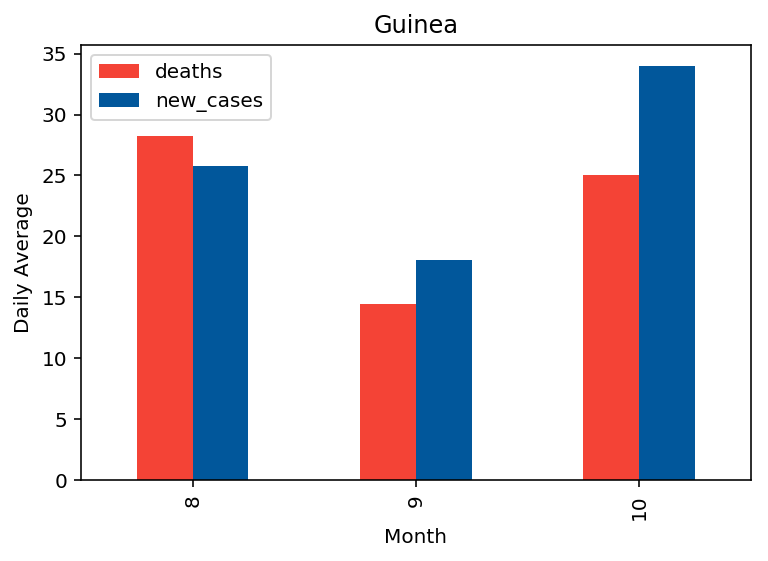

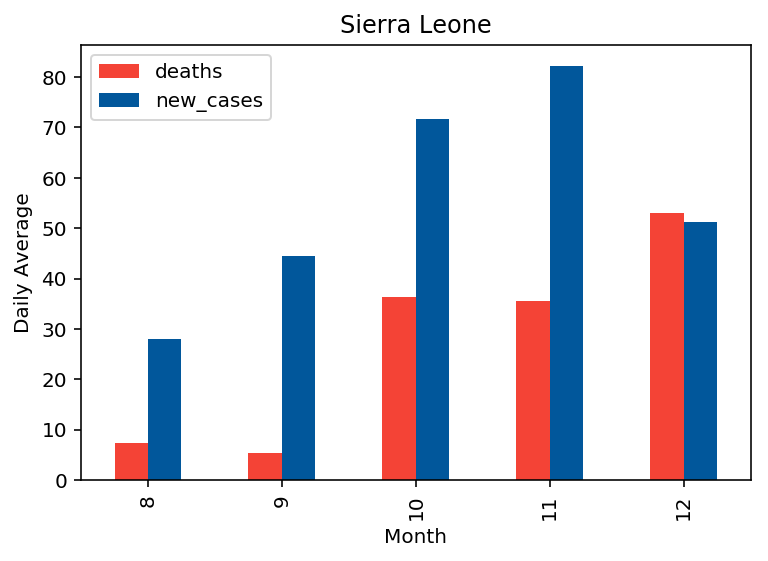

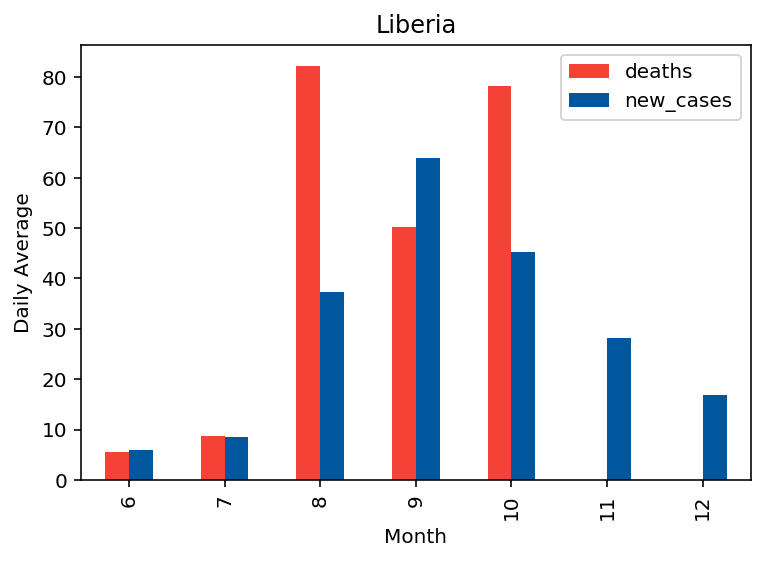

In [17]:
print("We can see it as a beautiful histogram instead:")

color_choices = ['#f44336','#01579b']
meaned_group_df = grouped_df.mean()

bar_guinea = meaned_group_df.xs('Guinea', level='Country').plot(kind='bar',title ="Guinea", color=color_choices)
bar_guinea.set_xlabel("Month")
bar_guinea.set_ylabel("Daily Average")

bar_sl = meaned_group_df.xs('Sierra Leone', level='Country').plot(kind='bar', title ="Sierra Leone", color=color_choices)
bar_sl.set_xlabel("Month")
bar_sl.set_ylabel("Daily Average")

bar_liberia = meaned_group_df.xs('Liberia', level='Country').plot(kind='bar', title ="Liberia", color=color_choices)
bar_liberia.set_xlabel("Month")
bar_liberia.set_ylabel("Daily Average")

plt.show()

The results are satisfying and make sense. Apart from two months in Liberia, we can see that in November and December, its average of cases is 0. This is due to the fact that we had no data for these two months in the columns that we chose. There was some data in the column "Newly reported deaths" but it was highly inconsistent with the data of the other columns, and we assumed it was not counting the exact same thing. Hence we decided to keep the total at zero and say we have no data for these two months.

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

The following function will be used to create all of our dataframes:

In [18]:
microbiome = DATA_FOLDER + '/microbiome/'
"""
Creates a DataFrame from a given xls
file.

returns the DataFrame
"""
def create_df(name, group, sample):
    df = pd.read_excel(microbiome + name +'.xls', header=None )
    
    # Sets the indices
    df.columns = ['Name', 'Count']
    df.set_index('Name', inplace=True)
    
    # Adds multiple leveled columns
    col = pd.MultiIndex.from_product([[group], [sample]], names=['Group', 'Sample'])
    df.columns = col
    
    return df

Let's import the data ! We start by importing the metadata, and we use it to import and create our DataFrame.

In [19]:
metadata = pd.read_excel(DATA_FOLDER + '/microbiome/metadata.xls')
metadata.fillna('unknown', inplace=True)

# From the metadata dataframe we create a
# unique Dataframe with all of the other files
data = []
for index, row in metadata.iterrows():
    data.append(create_df(row['BARCODE'], row['GROUP'], row['SAMPLE']))
microbiome_df = pd.concat(data, axis=0)

Now that we have our DataFrame, let's group it and check wether our index is unique. We finish by printing it out.

In [20]:
# We make the index unique by summing rows with same index
microbiome_df = microbiome_df.groupby(microbiome_df.index).sum()
microbiome_df.fillna('unknown', inplace=True)
print("Index unique: ", microbiome_df.index.is_unique)
display(HTML(microbiome_df.to_html()))

Index unique:  True


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [21]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

### Importing the data

In [22]:
titanic_df = pd.read_excel(DATA_FOLDER +'/titanic.xls')
display(HTML(titanic_df.to_html()))

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


### 3.1 Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 

We start by describing the columns, where we can find some information about each column, namely the data types for example.

In [23]:
titanic_df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

So, there are a few columns that are obviously integers, when we count something for example, or when we want to categorize something (we will see more about that later), hence the integer columns are: *pclass*, *survived*, *sibsp* and *parch*. We could argue that a few other columns should be integers, for example the *age*, the *ticket* number or even the *boat* number. But after taking a look at the data, each of these are strings or double for a reason. Some of these columns will be categorized later on, we will talk about that later.

We chose to let the *age* column as is, in order to create a new one containing the *age* categorized. As for the object ones, they are all strings, that pandas interprets as objects. The *age* is a float since for young infants it is written as a continuous age between 0 and 1 for example and sometimes "half year" is counted (18.5 etc.). The *fare* is also a a float to account for the cents. As for the body, it is counted as a float mainly because of the NaNs which prevents the column to be integers.

The only value ranges that are of any interest to us are the ones from the integer and float columns since the others will be categorized. We can take a look at the description given by pandas to see the value ranges directly:

In [24]:
titanic_df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


*pclass*, *survived*, and *body* are categories and hence not really interesting for value ranges. So we will focus on the other few. The *age* tells us that there were young infants on the boat but also old people, it ranges from 0.1667 which is considered as an infant between 0 and 1, up to 80 years old. *sibsp* or the number of siblings/spouses aboard ranges from 0 to 8, meaning that there were single travelers, but also big families of up to 8 people. We can say exactly the same for *parch* which is the number of parents/children aboard, it ranges from 0 to 9, that confirms the bit about big families being onboard. And the *fare* ranges from 0 british pounds to about 512 british pounds.

Now onto categorizing: *survived* should be categorical: a simple yes or no (boolean), as well as *pclass* which seems to be the ticket's class, in the other columns we have the *sex* that is also a category, the *cabin*, the *body*, the *embarked* column which is the port of origin, the *boat* number, the *home.dest*, the *ticket* and *name* can also be considered as categorical. We decided to change the discretization of some of the categories to have them make more sense.

Let's now apply all of the changes that we talked about:

In [25]:
# Categorizing
to_categorize = ['pclass', 'survived', 'name', 'sex', 'cabin', 'body', 'embarked', 'ticket', 'boat', 'home.dest']
titanic_df[to_categorize] = titanic_df[to_categorize].apply(lambda c: c.astype('category'))

categorization_map = {'pclass': {1: 'First class', 2: 'Second class', 3: 'Third class'},
                      'survived': {1: True, 0: False},
                      'sex': {"female": "Female", "male": "Male"},
                      'embarked': {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton" }
                     }

# Modifying some columns
for column in categorization_map.keys():
    titanic_df[column] = titanic_df[column].map(categorization_map[column])
    
# Let's create a new column for ages cut in 4 quantiles
titanic_df['age_block'] = pd.qcut(titanic_df.age, 4).astype('category')

print("Here is the Titanic DataFrame that we will work with:")
display(HTML(titanic_df.to_html()))

Here is the Titanic DataFrame that we will work with:


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,age_block
0,First class,True,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.3375,B5,Southampton,2,NaN,"St Louis, MO","(28.0, 39.0]"
1,First class,True,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON","(0.166, 21.0]"
2,First class,False,"Allison, Miss. Helen Loraine",Female,2.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON","(0.166, 21.0]"
3,First class,False,"Allison, Mr. Hudson Joshua Creighton",Male,30.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON","(28.0, 39.0]"
4,First class,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON","(21.0, 28.0]"
5,First class,True,"Anderson, Mr. Harry",Male,48.0000,0,0,19952,26.5500,E12,Southampton,3,NaN,"New York, NY","(39.0, 80.0]"
6,First class,True,"Andrews, Miss. Kornelia Theodosia",Female,63.0000,1,0,13502,77.9583,D7,Southampton,10,NaN,"Hudson, NY","(39.0, 80.0]"
7,First class,False,"Andrews, Mr. Thomas Jr",Male,39.0000,0,0,112050,0.0000,A36,Southampton,NaN,NaN,"Belfast, NI","(28.0, 39.0]"
8,First class,True,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",Female,53.0000,2,0,11769,51.4792,C101,Southampton,D,NaN,"Bayside, Queens, NY","(39.0, 80.0]"
9,First class,False,"Artagaveytia, Mr. Ramon",Male,71.0000,0,0,PC 17609,49.5042,NaN,Cherbourg,NaN,22.0,"Montevideo, Uruguay","(39.0, 80.0]"


### 3.2 Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

We simply plot the sort_index of the value_counts which gives us what the question asked for directly.

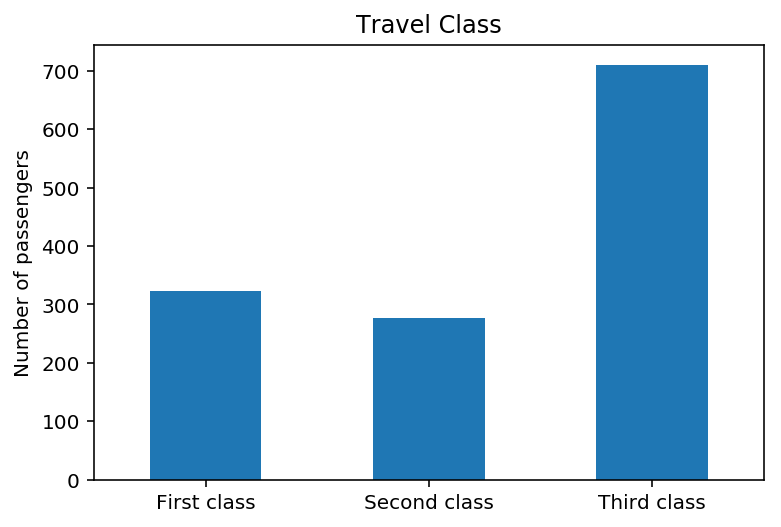

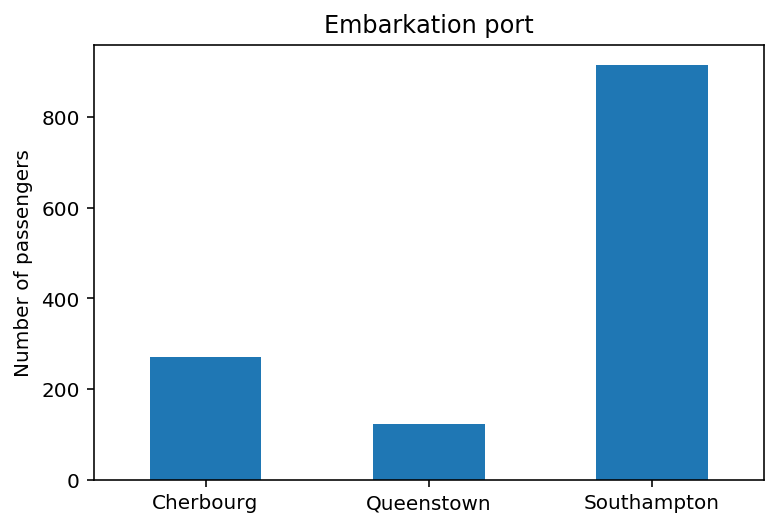

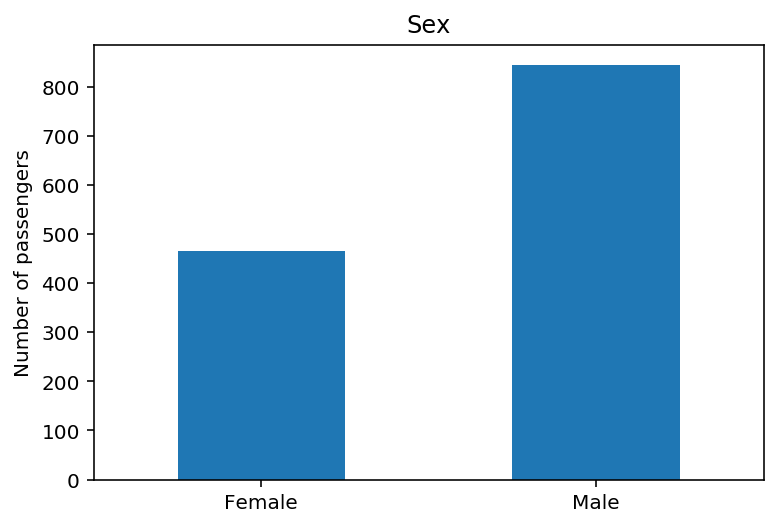

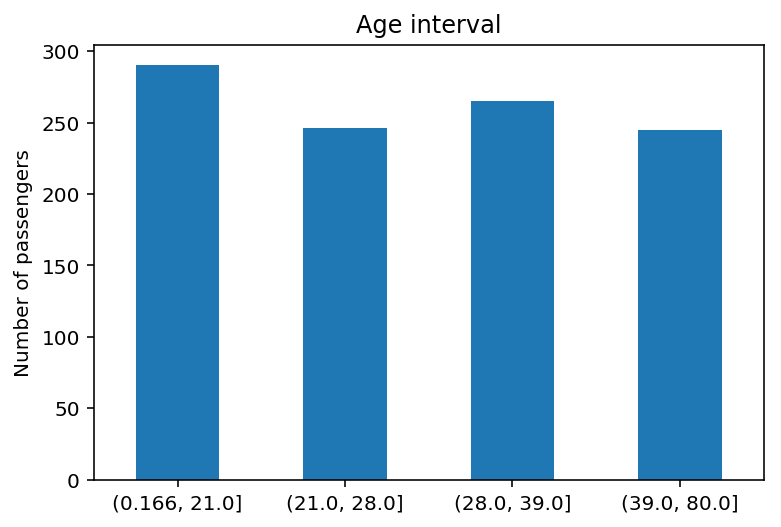

In [26]:
# Attributes we want to plot,
# with corresponding titles
to_plot = { 'pclass': 'Travel Class',
            'embarked': 'Embarkation port',
            'sex': 'Sex',
            'age_block': 'Age interval'
          }

# We plot the number of passengers for
# each selected attribute's category (or intervals).
for c in to_plot:
    titanic_hist = titanic_df[c].value_counts().sort_index().plot(kind='bar',title = to_plot[c], rot=0)
    titanic_hist.set_ylabel("Number of passengers")
    plt.show()

### 3.3 Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

The cabin floor is represented by the letter preceding the variable cabin. We drop the NaN values to compute better statistics. And here is the proportion of passengers by cabin floor.

In [27]:
cabin_series = titanic_df['cabin'].dropna()
# Retaining only the first letter
cabin_series = cabin_series.apply(lambda x: x[0])
print("Here are the cabin floors: {}".format(', '.join(cabin_series.unique())))

Here are the cabin floors: B, C, E, D, A, T, F, G


We can see a floor called "T" that does not appear on the map of the Titanic, hence it must be a typo or another problem. We then remove it.

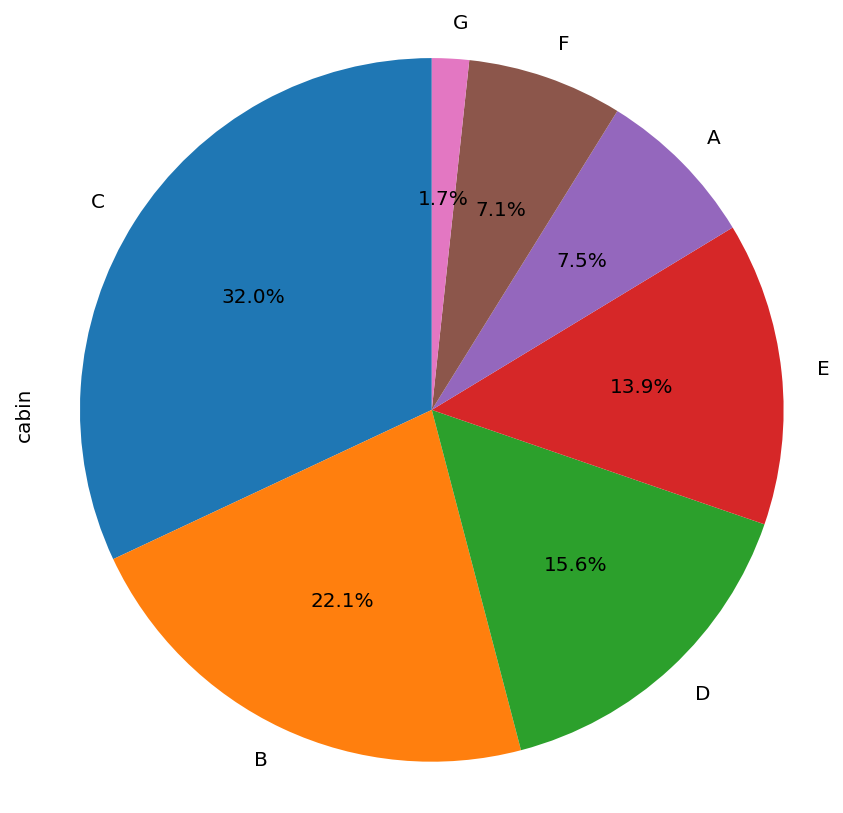

In [28]:
# Removing T
cabin_series= cabin_series[cabin_series != 'T']

# Let's count them !
cabin_series.value_counts().plot.pie(figsize=(7, 7),  autopct='%1.1f%%',
        startangle=90)
plt.axis('equal')
plt.show()

### 3.4 For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

Again we start by dropping the rows with NaN values to compute better statistics. We then group the pclass and survived columns to finally compute the proportion of passengers that survived.

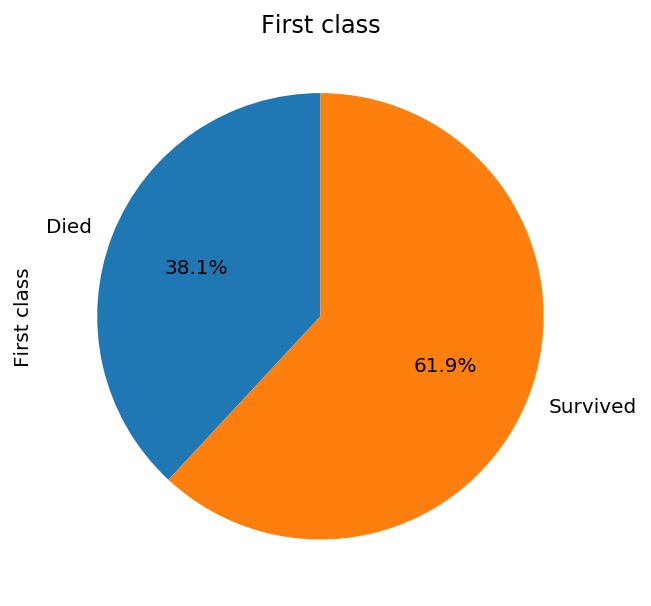

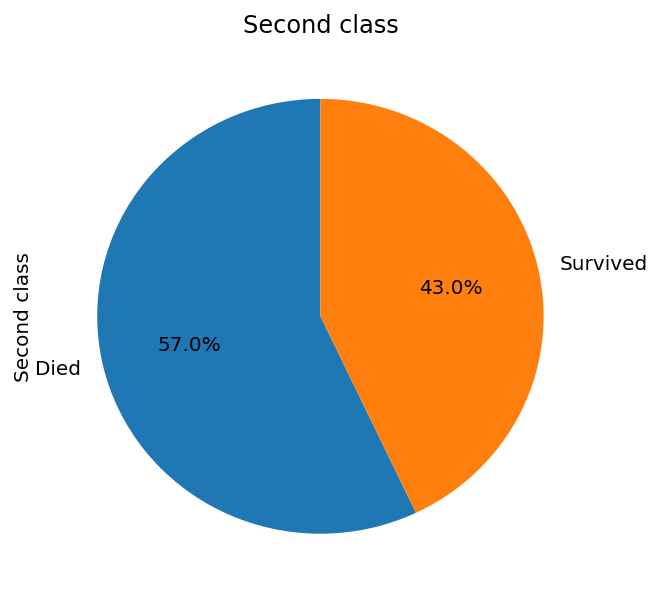

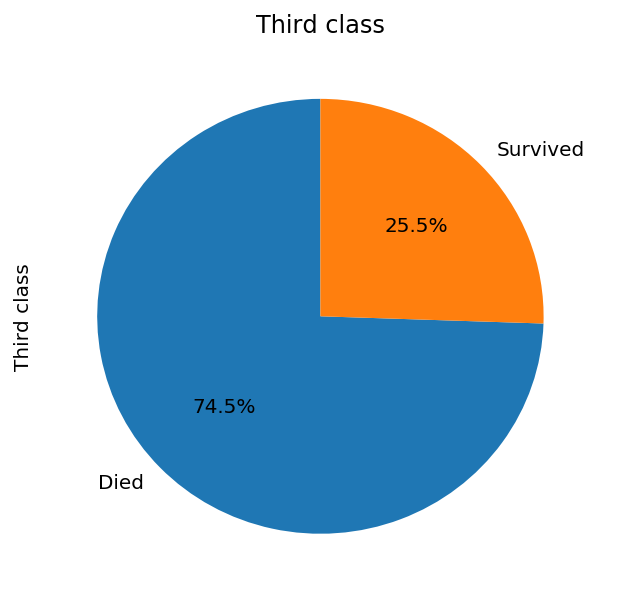

In [29]:
class_survived_df = titanic_df[['pclass', 'survived']].dropna()
class_survived_df = pd.DataFrame(class_survived_df.groupby(['pclass', 'survived'])
                                 .size()).unstack('survived')
class_survived_df.columns = class_survived_df.columns.droplevel()
class_survived_df.rename(columns={True: "Survived", False: "Died"}, inplace=True)

plt.axis('equal')
for pclass in class_survived_df.index:
    plt.title(pclass)
    class_survived_df.loc[pclass].plot.pie(figsize=(5, 5),
                                            autopct='%1.1f%%', startangle=90)
    plt.show()

Obviously, you really wanted to be in First class at the time.

### 3.5 Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

We start by creating a DataFrame with only the asked attributes and we group them to be able to count them afterwards.

In [30]:
titanic_grouped = titanic_df.groupby(['pclass', 'sex', 'survived'])
titanic_grouped = titanic_grouped.size()
titanic_grouped = titanic_grouped.unstack('survived')

Now let's compute the proportion needed and print the obtained DataFrame before building the histogram.

In [31]:
titanic_grouped['prop_true'] = titanic_grouped[True] * 100 / titanic_grouped.sum(1)
print("Here the proportion of the passengers that survived by travel class and sex:")
display(HTML(titanic_grouped.to_html()))

Here the proportion of the passengers that survived by travel class and sex:


Let's see it more clearly using a histogram:

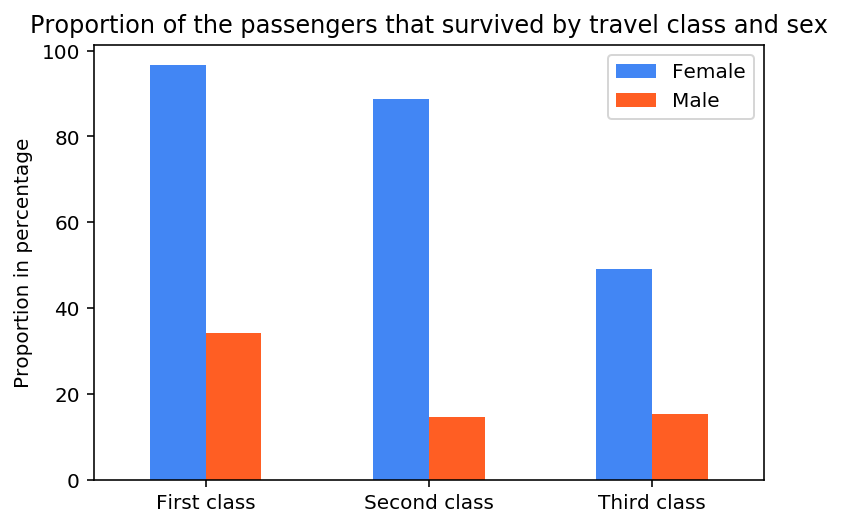

In [32]:
titanic_prop = titanic_grouped[['prop_true']].unstack('sex')
titanic_prop.columns = titanic_prop.columns.droplevel().rename('')
titanic_prop.index.rename('', inplace = True)

# Let's make it pretty
color_cs = ['#4286f4', '#ff5e23']
titanic_class_sex = titanic_prop.plot(kind='bar', rot=0, color=color_cs)
titanic_class_sex.set_title('Proportion of the passengers that survived by travel class and sex')
titanic_class_sex.set_ylabel("Proportion in percentage")

plt.show()

As we see again, we clearly wanted to be a woman, and in first class at the time !

### 3.6 Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

Let's focus on the age, the class, the sex and if the person survived. Using them, we split the ages into two categories, before 28 years old and after. 28 is the age splitting the best the age distribution.

In [33]:
titanic_agecat = titanic_df[['age', 'pclass', 'sex', 'survived']]

# We create 2 equally populated age categories
titanic_agecat['age_interval'] = pd.qcut(titanic_agecat['age'], 2)

titanic_agecat_gb = titanic_agecat.groupby(['age_interval', 'pclass', 'sex', 'survived'])
titanic_agecat_gb = titanic_agecat_gb.size()
titanic_agecat_gb = titanic_agecat_gb.unstack('survived')

And we finally compute the proportions asked in the question. And check if the index is unique.

In [34]:
# Computing the proportion
titanic_agecat_gb['proportion_survived'] = titanic_agecat_gb[True] * 100 / titanic_agecat_gb.sum(1)

# Removing all the other columns
titanic_agecat_gb = titanic_agecat_gb[['proportion_survived']]
titanic_agecat_gb.columns.rename('', inplace=True)

display(HTML(titanic_agecat_gb.to_html()))
print('We can finally verify that the DataFrame has a unique index : ', titanic_agecat_gb.index.is_unique)

We can finally verify that the DataFrame has a unique index :  True
